In [1]:
import sqlalchemy
from os import environ

import numpy as np
import pandas as pd

from jupyter_dash import JupyterDash
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
from dash import dcc

from sklearn.cluster import MeanShift

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## The ESPN fantasy league assigns value to some recorded player statistics. The values include:

- Points scored PTS = 1
- Blocks BLK = 4
- Assists AST = 2
- Rebounds REB = 1
- Field goals made FGM = 2
- Free throws made FTM = 1
- Three pointers made PM3 = 1
- Steals STL = 4

## Some values result in a penalty (negative scores):

- Turnovers TOV = -2
- Field goals attempted FGA = -1
- Free throws attempted FTA = -1

In [2]:
value = {"PTS":1,"BLK":4,"AST":2,"REB":1,"TOV":-2,"FGM":2,"FGA":-1,"FTM":1,"FTA":-1,"PM3":1,"STL":4}

### The fantasy scores are given as :
$$score = \sum^{N-1}_{i=0} v_i \cdot s_i$$

Where $v_i$ is the value assigned to stat $s_i$.

In [3]:
v = np.array(list(value.values()))

In [4]:
stats = ", ".join(list(value.keys()))

In [5]:
engine = sqlalchemy.create_engine("mariadb+mariadbconnector://"+environ.get("USER")+\
                                  ":"+environ.get("PSWD")+"@127.0.0.1:3306/nba")

In [6]:
# csv = pd.read_sql("SELECT Name, Box_scores.* FROM Box_scores INNER JOIN Players on Box_scores.Player_ID = Players.ID ORDER BY Game_day desc",engine,parse_dates=["Game_day"])

In [7]:
# csv.to_csv("box_scores.csv",index=False)

In [8]:
fields = "Name, " + stats + ", Game_day "

join =  "Box_scores INNER JOIN Players on Box_scores.Player_ID = Players.ID "

select = "SELECT "+ fields + " FROM " + join + "ORDER BY Game_day desc"

In [9]:
box_scores = pd.read_sql(select,engine,parse_dates=["Game_day"])

## Calculate the fantasy points by a matrix multiplication
$$\vec{f} = \vec{v} \times \matrix{B} $$

Where $\vec{f}$ is all player's fantasy points, $\vec{v}$ is the values assigned to the all player's box scores $\matrix{B}$.

In [10]:
def calc_fantasy_points(v, box_scores):
    return v @ box_scores

In [11]:
s = np.array(box_scores.values[:,1:-1],dtype = np.int64)

In [12]:
box_scores["Fantasy Points"] = calc_fantasy_points(v, s.T)

## The fantasy scores can then be grouped by the player names and aggregated using a rolling mean on their fantasy scores.

Typically, there are 3-4 games a week and since the Fantasy League is in a week-by week format, it makes sense to set the rolling mean window to 4. This will show how a player is doing on a week to week basis.

In [13]:
names = box_scores["Name"].unique()

In [14]:
rolls = box_scores[['Name',"Game_day",'Fantasy Points']]
# rolls= box_scores.sort_values("Game_day", ascending=True).groupby("Name").rolling(4,min_periods =1).mean()
rolls= rolls.sort_values("Game_day", ascending=True).\
groupby("Name",as_index=False).rolling(4,min_periods =1).mean()

In [15]:
# r = box_scores[['Name',"Game_day",'Fantasy Points']]
# rolls= box_scores.sort_values("Game_day", ascending=True).groupby("Name").rolling(4,min_periods =1).mean()
# r= r.sort_values("Game_day", ascending=True).\
# groupby("Name").rolling(4,min_periods =1).mean()

In [16]:
fps = box_scores.groupby("Name",as_index=False).mean()

In [17]:
box_scores["Rolling"] = rolls["Fantasy Points"]

In [18]:
def options(names):
    options = []
    for i in names:
        d = {}
        d["label"] = i
        d["value"] = i
        options.append(d)
        
    return options

## Below defines a dashboard that shows a line graph for aggregated fantasy scores against the game day. A searchable dropdown includes all the players who recorded stats this season. Simply search and select the player(s) of interest and their fantasy points over the course of the season will be visible. The dropdown includes functionality for multiple players to enable multiple comparisons. 

## A second graph, a (overlaid) histogram with the marginal plots for the fantasy points counts is included to show the distribution of fantasy points for the selected players.

In [19]:
def drpdwn(i):
    opts = options(names)
    d = dcc.Dropdown(options = opts, value = names[0:2],id = i,multi = True)
    
    return d

In [20]:
# model = MeanShift(bandwidth = 3.6, min_bin_freq = 1)

In [21]:
# model.fit(fps["Fantasy Points"].values.reshape((-1,1)))

In [22]:
# labs = {0:'Horrible',2:'Avoid',1:'Temporary',3:'Average',4:'Underrated',
#         5:'Good',6:'Great',7:'Super',8:'Outstanding'}

In [23]:
# box_scores['Rating'] = [labs[i] for i in model.predict(box_scores['Rolling'].values.reshape((-1,1)))]

In [24]:
box_scores.loc[box_scores['Name'].isin(['Kevin Huerter','Patrick Beverley'])].sort_values("Game_day",ascending=False)

,Name,PTS,BLK,AST,REB,TOV,FGM,FGA,FTM,FTA,PM3,STL,Game_day,Fantasy Points,Rolling
195,Kevin Huerter,21,1,4,2,1,8,13,0,0,5,1,2022-04-05,45,32.750000
535,Kevin Huerter,5,0,0,4,1,2,10,0,0,1,0,2022-04-02,2,32.250000
620,Patrick Beverley,9,0,4,5,1,2,8,5,6,0,6,2022-04-01,39,24.750000
852,Kevin Huerter,23,0,2,2,1,7,12,4,4,5,2,2022-03-31,42,40.500000
1000,Kevin Huerter,20,0,1,2,2,8,10,0,0,4,3,2022-03-30,42,33.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24139,Patrick Beverley,13,1,2,2,0,4,6,1,2,4,1,2021-10-25,32,28.500000
24198,Kevin Huerter,14,0,4,1,1,5,8,2,2,2,1,2021-10-25,29,16.333333
24496,Patrick Beverley,5,1,6,3,1,2,6,0,0,1,1,2021-10-23,25,25.000000
24572,Kevin Huerter,4,0,2,1,1,2,9,0,0,0,1,2021-10-23,6,10.000000


In [25]:
don = box_scores.loc[box_scores['Name'].isin(names[0:2])]

fig = px.line(y="Rolling", x="Game_day",color="Name",data_frame = don, markers=True,range_y=(0,100))
fig.update_layout(title ="Fantasy points during current season", xaxis_title = "Game Day",
                  title_x = 0.5,yaxis_title = "4 game Rolling mean / Fantasy points")

fig2 = px.histogram(don, x= "Fantasy Points",color = "Name",marginal = 'box',barmode='overlay',
                    histnorm="probability")

fig3 = px.ecdf(don,x="Fantasy Points",color="Name")
app = JupyterDash(__name__)
# colours = {'text': '#7FDBFF', 'background':'#333333','radio_button':'#BBBBBB'} 
# text_size = {'H1':48,'H2':40,'text':28,'radio_button':20}

app.layout = html.Div(className="p-heading",
                      children=[html.H1(children="ESPN Fantasy Analysis"),
                                html.Div(children=[drpdwn('g1'), dcc.Graph(figure = fig, id = 'graph')]),
                                html.Div(children=[dcc.Graph(figure = fig2, id = 'graph2')]),
        html.Div(children=[dcc.Graph(figure = fig3, id = 'graph3')])
])

@app.callback(
    Output('graph','figure'),
    Output('graph2','figure'),
    Output('graph3','figure'),
    Input('g1','value'))
def update_figure(selected):
    d = box_scores.loc[box_scores['Name'].isin(selected)]
    
    fig = px.line(y="Rolling", x="Game_day",color="Name",data_frame = d, markers=True,range_y=(0,100))
    
    fig.update_layout(title ="Fantasy points during current season", xaxis_title = "Game Day",
                  title_x = 0.5,yaxis_title = "4 game Rolling mean / Fantasy points")
    
    fig2 = px.histogram(d, x= "Fantasy Points",color = "Name",marginal = 'box',barmode='overlay',
                        histnorm="probability")
    
    fig3 = px.ecdf(d,x="Fantasy Points",color="Name")

    
    return fig,fig2,fig3

In [26]:
app.run_server(mode = "external")

Dash app running on http://127.0.0.1:8050/


In [27]:
import matplotlib.pyplot as plt

In [28]:
def plot_fp_distribution(fps):
    fig = plt.figure(figsize=(15,2))
    ax = fig.add_axes([0,1,1,1])

    plt.vlines(x = fps, ymin = -0.01,ymax=0.01, colors='b')
    plt.ylim((-0.05,0.05))
    plt.xlim((0,max(fps)+1))
    plt.xlabel("Average Fantasy Points")
    plt.xticks(range(-5,70,5))
    
    return

In [29]:
fps['Rating'] = model.labels_

In [30]:
fps['Rating']  = [labs[i] for i in fps['Rating']]

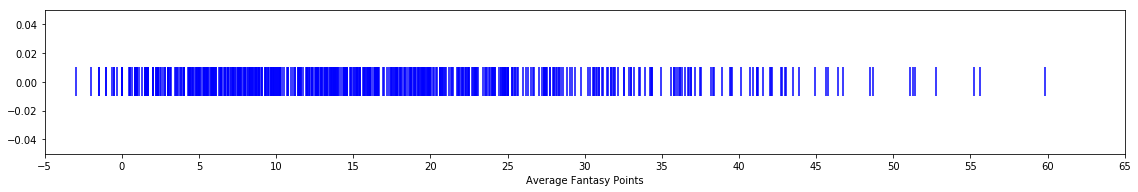

In [31]:
plot_fp_distribution(fps["Fantasy Points"])

In [32]:
don = box_scores.loc[box_scores['Name'].isin(['Donovan Mitchell','Joel Embiid','Russell Westbrook',
                                              'DeMar DeRozan','Carmelo Anthony','Luka Doncic',
                                              'Will Barton','Robert Covington','Marcus Morris Sr.'])]

In [33]:
don.head(7)

,Name,PTS,BLK,AST,REB,TOV,FGM,FGA,FTM,FTA,PM3,STL,Game_day,Fantasy Points,Rolling,Rating
0,Carmelo Anthony,17,2,1,7,4,6,12,4,4,1,0,2022-03-07,27,29.75,Avoid
8,Russell Westbrook,17,0,6,10,5,5,14,7,13,0,0,2022-03-07,19,26.25,Avoid
13,DeMar DeRozan,23,0,8,11,3,6,17,11,12,0,0,2022-03-07,38,40.25,Underrated
48,Joel Embiid,43,3,2,14,2,15,27,12,16,1,2,2022-03-07,77,51.25,Great
78,Donovan Mitchell,17,0,9,4,3,5,19,5,7,2,1,2022-03-07,28,37.25,Underrated
98,Luka Doncic,35,1,7,16,3,12,23,6,7,5,3,2022-03-07,80,57.75,Super
189,Marcus Morris Sr.,4,0,0,3,2,2,9,0,0,0,0,2022-03-06,-2,15.25,Temporary


In [34]:
greatness = ['Super','Outstanding','Great','Good']
underrated =['Average']
out = fps.loc[fps['Rating'].isin(underrated)]

In [35]:
labs.values()

dict_values(['Horrible', 'Avoid', 'Temporary', 'Average', 'Underrated', 'Good', 'Great', 'Super', 'Outstanding'])

In [36]:
out.sort_values("Fantasy Points",ascending=False)

,Name,PTS,BLK,AST,REB,TOV,FGM,FGA,FTM,FTA,PM3,STL,Fantasy Points,Rating
88,Christian Wood,17.900000,0.966667,2.233333,10.150000,1.800000,6.516667,13.200000,3.000000,4.933333,1.866667,0.766667,35.616667,Average
135,Deandre Ayton,16.604651,0.813953,1.418605,9.744186,1.627907,7.348837,11.465116,1.790698,2.511628,0.116279,0.790698,34.976744,Average
493,Russell Westbrook,18.126984,0.253968,7.190476,7.634921,3.952381,6.888889,15.904762,3.396825,5.111111,0.952381,1.000000,34.365079,Average
427,Myles Turner,12.857143,2.809524,1.047619,7.071429,1.285714,4.761905,9.357143,1.880952,2.500000,1.452381,0.666667,34.357143,Average
291,John Collins,16.634615,1.057692,1.865385,7.961538,1.115385,6.461538,12.057692,2.480769,3.153846,1.230769,0.634615,34.288462,Average
162,Draymond Green,7.882353,1.205882,7.352941,7.558824,3.117647,3.176471,5.911765,1.176471,1.970588,0.352941,1.382353,34.264706,Average
357,Kyle Kuzma,17.216667,0.916667,3.400000,8.716667,2.466667,6.433333,14.100000,2.416667,3.333333,1.933333,0.666667,33.916667,Average
540,Tobias Harris,17.909091,0.654545,3.490909,7.072727,1.672727,6.981818,14.654545,2.781818,3.254545,1.163636,0.581818,33.563636,Average
358,Kyle Lowry,13.102041,0.306122,7.816327,4.591837,2.897959,4.306122,10.204082,2.367347,2.775510,2.122449,1.163265,33.530612,Average
567,Tyrese Maxey,17.596491,0.473684,4.456140,3.508772,1.175439,6.508772,13.491228,3.000000,3.473684,1.578947,0.754386,33.210526,Average


In [37]:
select = "select Players.Name as Player, A.* from\
 (select Name, FGA,OREB,TOV,FTA, Player_ID from Box_scores inner join Teams on Box_scores.Team_ID = Teams.ID\
) A inner join Players on A.Player_ID = Players.ID"
nba = pd.read_sql(select,engine,parse_dates=["Game_day"])

In [38]:
nba["POSS"] = nba['FGA'] - nba['OREB'] + nba['TOV'] + 0.4*nba['FTA']

In [39]:
nba = nba.drop("Player_ID",axis=1)

In [40]:
nba_team = nba.groupby("Name").sum()

In [41]:
nba_team.sort_values("POSS",ascending=False)

,FGA,OREB,TOV,FTA,POSS
Name,,,,,
SAC,5941,671,907,1533,6790.2
MIN,6030,772,920,1485,6772.0
MEM,6182,924,828,1531,6698.4
CHA,5992,718,832,1418,6673.2
SAS,6067,720,804,1244,6648.6
HOU,5597,629,1033,1613,6646.2
IND,5884,734,893,1426,6613.4
LAC,5769,601,887,1268,6562.2
ORL,5716,589,909,1288,6551.2


In [42]:
nba_players = nba.groupby("Player").sum()

In [43]:
nba_players.sort_values("POSS",ascending=False).head(20)

,FGA,OREB,TOV,FTA,POSS
Player,,,,,
Trae Young,1211,38,237,412,1574.8
Jayson Tatum,1296,74,179,391,1557.4
DeMar DeRozan,1227,51,144,481,1512.4
Stephen Curry,1155,33,190,279,1423.6
Luka Doncic,1068,45,222,363,1390.2
Ja Morant,1079,70,179,377,1338.8
Devin Booker,1124,41,132,273,1324.2
Julius Randle,1079,112,220,333,1320.2
Giannis Antetokounmpo,991,108,180,611,1307.4


In [50]:
a=[i for i in range(10,0,-1)]

In [51]:
a.index(6)

4

In [ ]:
b = [(str(i[0]), str(i[1])) for i in enumerate(a)]

In [ ]:
d = dict(b)

In [ ]:
d

### "1"

In [ ]:
a = "1234"

In [ ]:
a = [i+1 for i in a]

In [ ]:
a = [2,2,2,2] + a

In [ ]:
a.remove(2)

In [ ]:
a

In [ ]:
for i in enumerate(a):
    print(i)